# <center> Bigmart sales prediction</center>
Aim is to build a predictive model and predict the sales of each product at a particular outlet. <br>
Link : https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/#ProblemStatement

In [80]:
#Load required libraries
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.lines as lines
from matplotlib.ticker import PercentFormatter
from IPython.display import HTML

from sklearn.preprocessing import LabelEncoder
from category_encoders import OrdinalEncoder
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV,RepeatedKFold
from mlxtend.preprocessing import standardize

In [81]:
#Visualization settings
sns.set_style(style='white')
sns.set(rc={
    'figure.figsize': (12,7),
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.color': '.9',
    'axes.linewidth': 1.0,
    'grid.linestyle': u'-'},
    font_scale=1.5)
custom_colors=["#3498db", "#95a5a6","#34495e", "#2ecc71", "#e74c3c"]
sns.set_palette(custom_colors)
background_color='#fbfbfb'

In [82]:
#function for loading input files, as we may need to refresh data several times.
df_train=pd.DataFrame()
df_test = pd.DataFrame()
def load_input_files():
    global df_train,df_test
    #Read input file
    df_train=pd.read_csv('train.csv')
    df_test=pd.read_csv('test.csv')
    
load_input_files()

In [83]:
print ("\nSample train dataframe:\n")
display(df_train.head(3))
print (f"\nShape of train dataframe: {df_train.shape}\n")
display(HTML("Feature names:"))
col_tags ="<ol>"+"".join([f"<li>{col}</li>" for col in df_train.columns]) + "<ol>"
display(HTML(col_tags))
print("\n Dataset summary \n")
print (df_train.info())

print ("\nSample test dataframe:\n")
display(df_test.head(3))
print (f"\nShape of train dataframe: {df_test.shape}\n")


Sample train dataframe:



,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700



Shape of train dataframe: (8523, 12)




 Dataset summary 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None

Sample test datafra

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.75,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.30,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.60,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store



Shape of train dataframe: (5681, 11)



<h4 style="background-color:#fbfbfb;font-family:serif;font-size:160%;">
    Float features   : 4 <br>
    Integer features : 1 <br>
    String features  : 7 <br>
    are present in the training data.
    </h4>

In [84]:
#Missing values in the training data
val = df_train.isnull().sum()
val.sort_values(inplace=True, ascending=False)

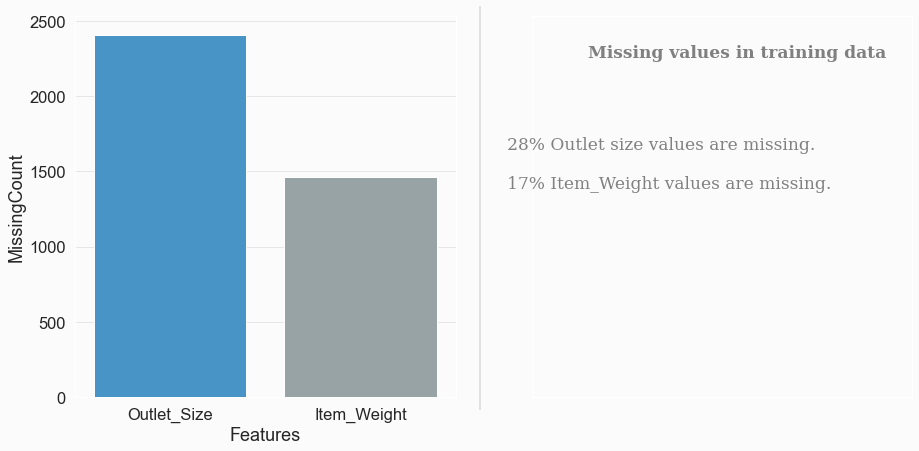

,Features,MissingCount
0,Outlet_Size,2410
1,Item_Weight,1463


In [85]:
df=pd.DataFrame(columns=["Features","MissingCount"])
df['Features']=val.index
df['MissingCount']=val.values
df.drop(df[df['MissingCount']==0].index,inplace=True)

#Create visualization for missing values
fig=plt.figure(figsize=(15,7))
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)

sns.barplot(data=df, x="Features", y="MissingCount", ax=ax0)

#Draw middle line
l1=lines.Line2D([0.5,0.5],[0.1,0.9], color='black', lw=0.2, transform=fig.transFigure)
fig.lines.extend([l1])

#Description
fig.text(x=0.6,
         y=0.8,
         s="Missing values in training data",
         fontweight='bold',
         fontfamily='serif',
         fontsize=17,
         color='grey' )
fig.text(x=0.47,
         y=0.5,
         fontweight='light',
         fontfamily='serif',
         fontsize=17,
         color='grey',
         s='''
           28% Outlet size values are missing.\n
           17% Item_Weight values are missing.
        ''')

plt.show()
display(df)
del(df)


## <center>Feature Analysis</center>

In [86]:
#Discrete feature analysis
def analyze_discrete_feature(fld,display_graph=True):
    print ("Sample data:\n")
    display(fld.head())
    df=pd.DataFrame({"Value": fld.value_counts().index,
                 "Count":fld.value_counts().values})
    print ("\nNull value count : ", fld.isnull().sum())
    unique_list=fld.unique().tolist()
    print ("\nUnique values: ", unique_list)
    print ("\n Unique values count: ", len(unique_list))
    print ("\nValue counts:\n",    df)
    if display_graph==True:
        plt.subplots(figsize=(25,10),facecolor=background_color)
        plt.subplot(2,2,1)
        plt.pie(fld.value_counts(),labels=fld.value_counts().index,autopct=lambda x: f'{x: .2f}%');
        plt.xticks(rotation=90)

        plt.subplot(2,2,2)   
        sns.barplot(data=df, x="Value",y="Count").set_facecolor(background_color);
        plt.xticks(rotation=90);
        plt.suptitle(fld.name + " -distribution");

        plt.show()
        plt.close()
    display(HTML("<h4 style='background-color:#fbfbfb;font-family:serif;font-size:160%'>Discrete variable</h4>"))

In [87]:
#Continuous feature analysis
def analyze_continuous_feature(fld):
    print ("Sample data:\n",df_train.Item_Weight.head())
    print ("\nNull value count : ", fld.isnull().sum())
    print ("\n", fld.describe())
    print (f"\n Skewness : {fld.skew()} \n")
    plt.subplots(figsize=(25,10))
    plt.subplot(2,2,1)
    plt.hist(fld)
    plt.subplot(2,2,2)
    sns.boxplot(fld)
    plt.suptitle(fld.name + "-distribution")
    plt.show()
    plt.close()
    display(HTML("<h4 style='background-color:#fbfbfb;font-family:serif;font-size:160%'>Continuous variable</h4>"))

## 1. Item_Identifier
	Unique product ID

In [88]:
print ("Sample data :\n")
display (df_train.Item_Identifier.head())
print (f"\nNumber of unique values : {df_train.Item_Identifier.nunique()}")



Sample data :



0    FDA15
1    DRC01
2    FDN15
3    FDX07
4    NCD19
Name: Item_Identifier, dtype: object


Number of unique values : 1559


<h4 style="background-color:#fbfbfb;font-family:serif;font-size:160%;">
    Looks like just an identifier column. Doesn't seems like much value for out model building.</h4>

## 2. Item_weight
	Weight of product

Sample data:
 0     9.30
1     5.92
2    17.50
3    19.20
4     8.93
Name: Item_Weight, dtype: float64

Null value count :  1463

 count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

 Skewness : 0.0824262091221237 



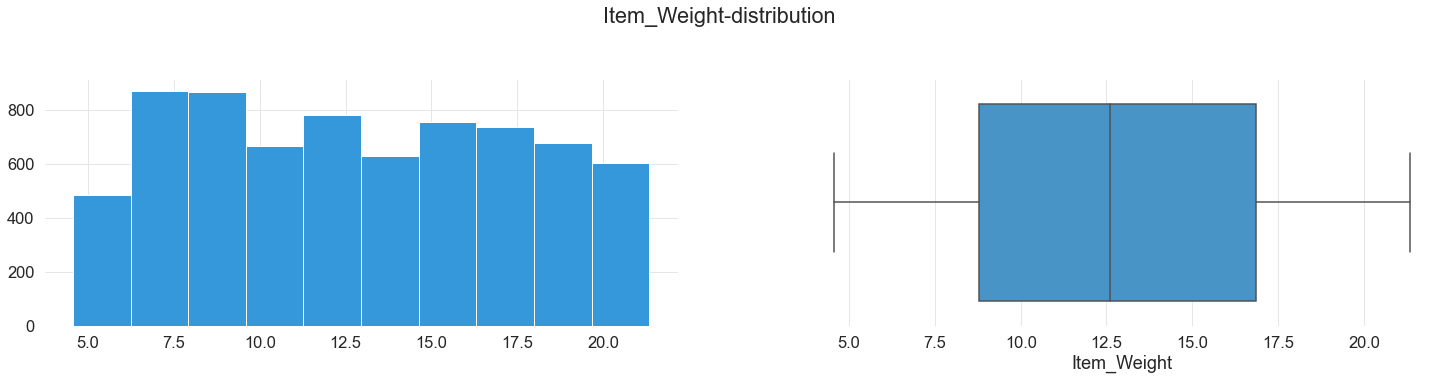

In [89]:
analyze_continuous_feature(df_train.Item_Weight)

<h4 style="background-color:#fbfbfb;font-family:serif;font-size:160%;">
    Item weight is decimal feature ranging from 4.5 to 21.35<br>
    </h4>

## 3. Item_Fat_Content
	Whether the product is low fat or not

Sample data:



0    Low Fat
1    Regular
2    Low Fat
3    Regular
4    Low Fat
Name: Item_Fat_Content, dtype: object


Null value count :  0

Unique values:  ['Low Fat', 'Regular', 'low fat', 'LF', 'reg']

 Unique values count:  5

Value counts:
      Value  Count
0  Low Fat   5089
1  Regular   2889
2       LF    316
3      reg    117
4  low fat    112


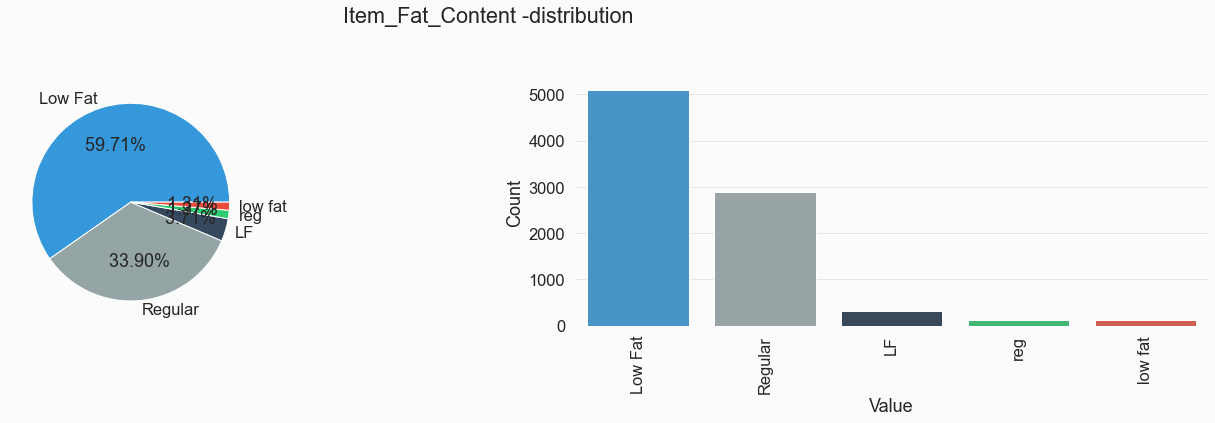

In [90]:
analyze_discrete_feature(df_train.Item_Fat_Content)

<h4 style="background-color:#fbfbfb;font-family:serif;font-size:160%;">
Almost 60% pf the items are with low fat content.
</h4>

## 4. Item_Visibility 
	The % of total display area of all products in a store allocated to the particular product

Sample data:
 0     9.30
1     5.92
2    17.50
3    19.20
4     8.93
Name: Item_Weight, dtype: float64

Null value count :  0

 count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

 Skewness : 1.1670905496918407 



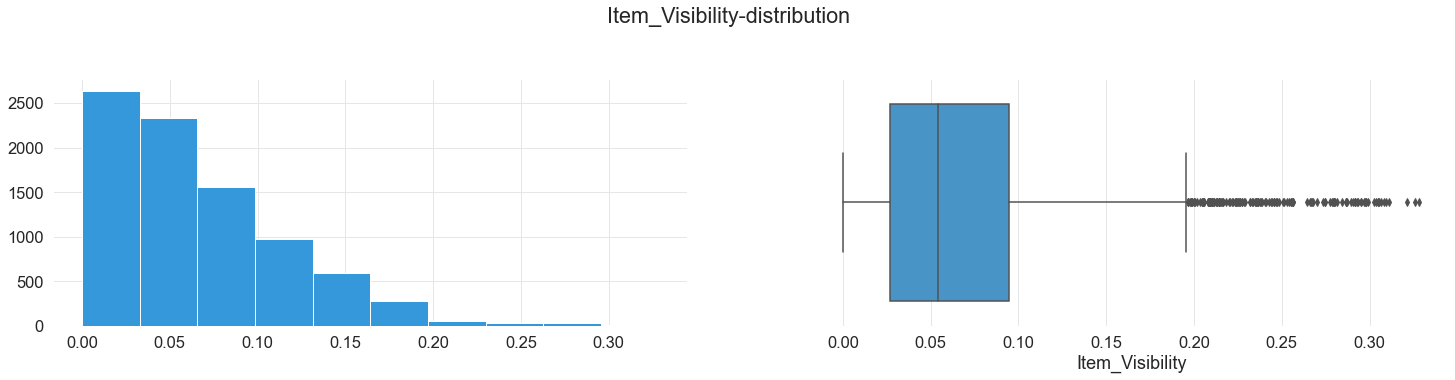

In [91]:
analyze_continuous_feature(df_train.Item_Visibility)

## 5. Item_Type
	The category to which the product belongs

Sample data:



0                    Dairy
1              Soft Drinks
2                     Meat
3    Fruits and Vegetables
4                Household
Name: Item_Type, dtype: object


Null value count :  0

Unique values:  ['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables', 'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods', 'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned', 'Breads', 'Starchy Foods', 'Others', 'Seafood']

 Unique values count:  16

Value counts:
                     Value  Count
0   Fruits and Vegetables   1232
1             Snack Foods   1200
2               Household    910
3            Frozen Foods    856
4                   Dairy    682
5                  Canned    649
6            Baking Goods    648
7      Health and Hygiene    520
8             Soft Drinks    445
9                    Meat    425
10                 Breads    251
11            Hard Drinks    214
12                 Others    169
13          Starchy Foods    148
14              Breakfast    110
15                Seafood     64


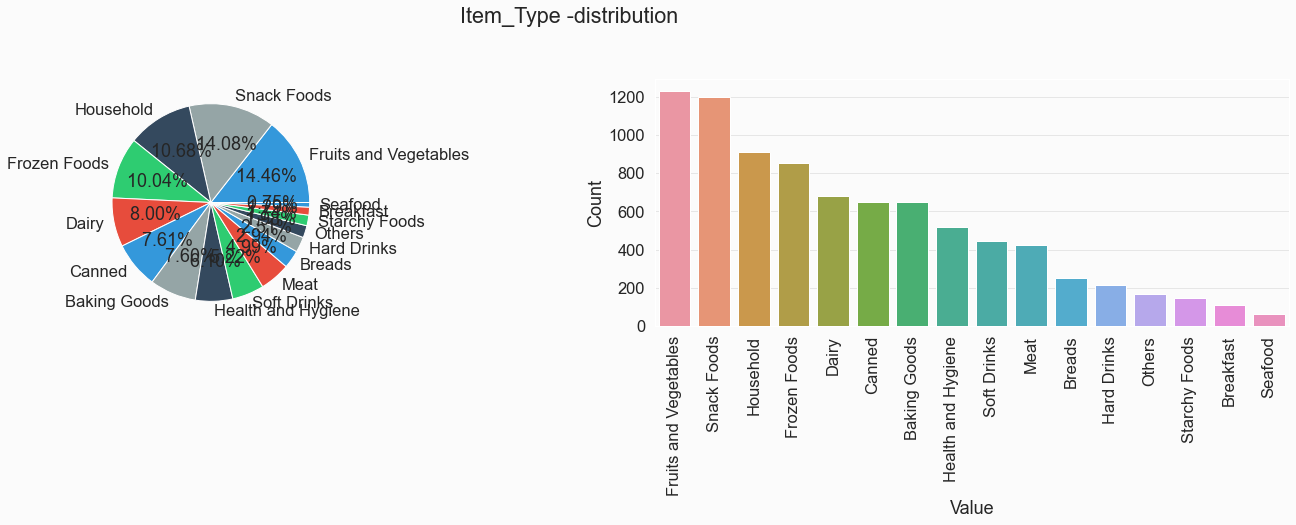

In [92]:
analyze_discrete_feature(df_train.Item_Type)

## 6. Item_MRP
	Maximum Retail Price (list price) of the product

Sample data:
 0     9.30
1     5.92
2    17.50
3    19.20
4     8.93
Name: Item_Weight, dtype: float64

Null value count :  0

 count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64

 Skewness : 0.1272022683110526 



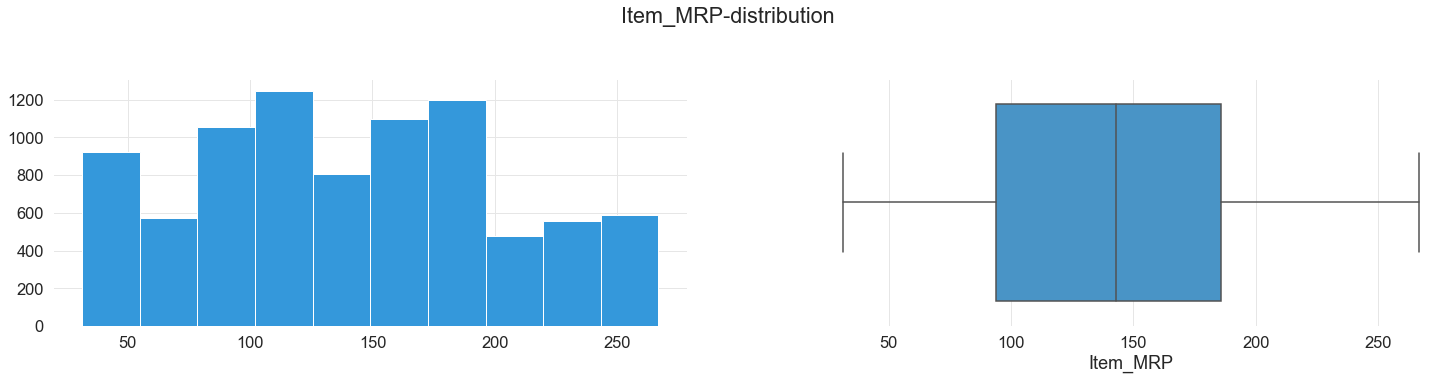

In [93]:
analyze_continuous_feature(df_train.Item_MRP)

<h4 style="background-color:#fbfbfb;font-family:serif;font-size:160%;">
MRP is ranging from 31.2 to 266.8
</h4>

## 7. Outlet_Identifier
Unique store ID

Sample data:



0    OUT049
1    OUT018
2    OUT049
3    OUT010
4    OUT013
Name: Outlet_Identifier, dtype: object


Null value count :  0

Unique values:  ['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045', 'OUT017', 'OUT046', 'OUT035', 'OUT019']

 Unique values count:  10

Value counts:
     Value  Count
0  OUT027    935
1  OUT013    932
2  OUT035    930
3  OUT049    930
4  OUT046    930
5  OUT045    929
6  OUT018    928
7  OUT017    926
8  OUT010    555
9  OUT019    528


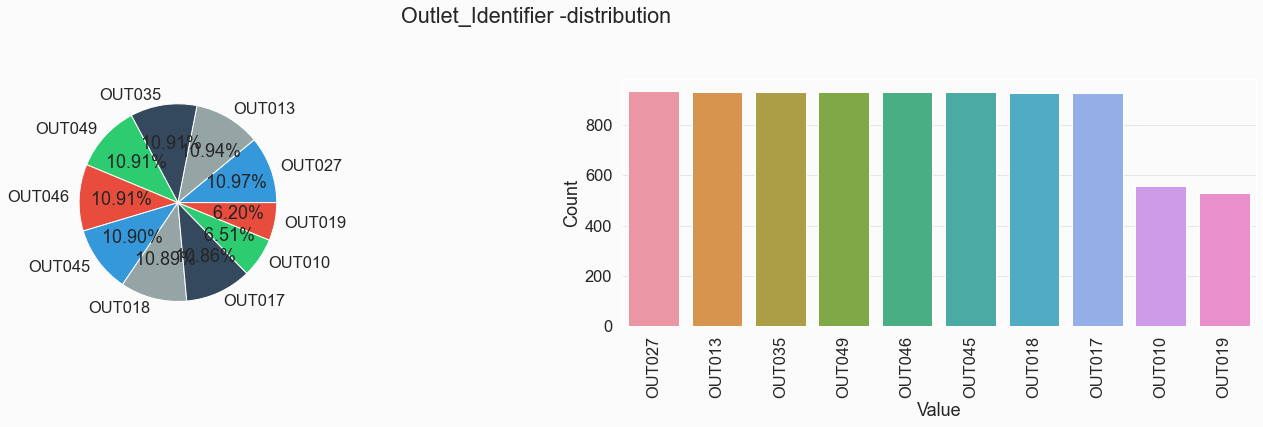

In [94]:
analyze_discrete_feature(df_train.Outlet_Identifier)

<h4 style="background-color:#fbfbfb;font-family:serif;font-size:160%;">
    Looks like almost all the outlets are in uniform distribution except OUT010 and OUT019.
    </h4>

## 8. Outlet_Establishment_Year
	The year in which store was established

Sample data:



0    1999
1    2009
2    1999
3    1998
4    1987
Name: Outlet_Establishment_Year, dtype: int64


Null value count :  0

Unique values:  [1999, 2009, 1998, 1987, 1985, 2002, 2007, 1997, 2004]

 Unique values count:  9

Value counts:
    Value  Count
0   1985   1463
1   1987    932
2   1999    930
3   1997    930
4   2004    930
5   2002    929
6   2009    928
7   2007    926
8   1998    555


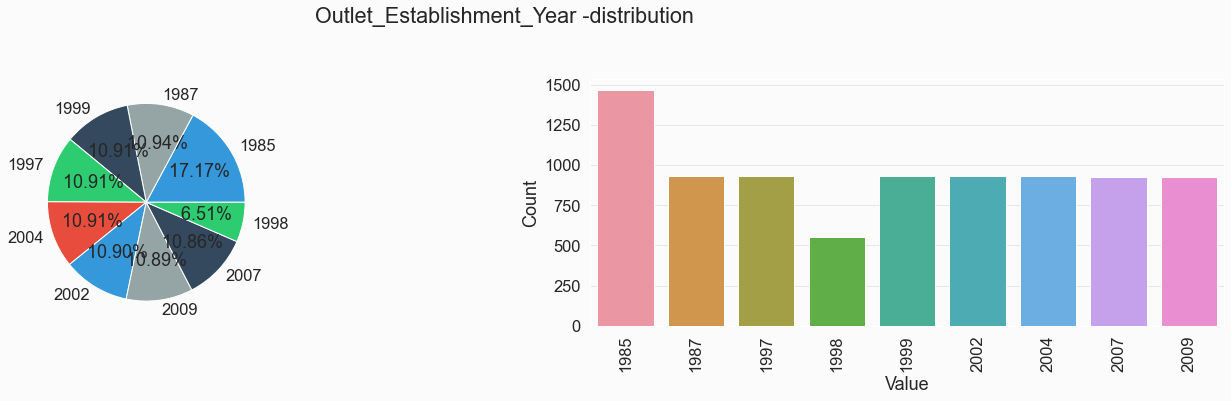

In [95]:
analyze_discrete_feature(df_train.Outlet_Establishment_Year)

<h4 style="background-color:#fbfbfb;font-family:serif;font-size:160%;">
    Compararitively there are more Outlets which established on 1985. <br>
    All other outlets are established uniformily except the one established on 1998.<br>
    </h4>

## 9. Outlet_Size
The size of the store in terms of ground area covered

Sample data:



0    Medium
1    Medium
2    Medium
3       NaN
4      High
Name: Outlet_Size, dtype: object


Null value count :  2410

Unique values:  ['Medium', nan, 'High', 'Small']

 Unique values count:  4

Value counts:
     Value  Count
0  Medium   2793
1   Small   2388
2    High    932


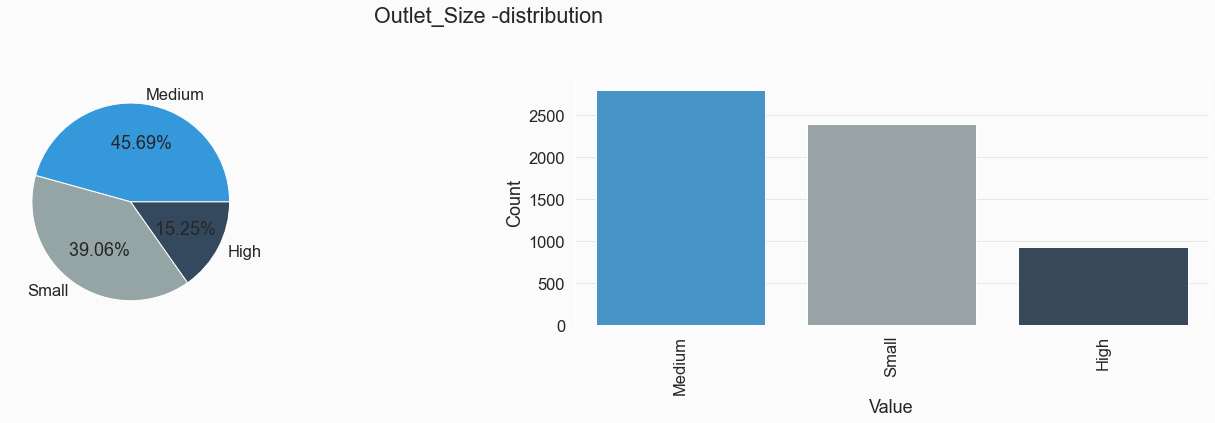

In [96]:
analyze_discrete_feature(df_train.Outlet_Size)

<h4 style="background-color:#fbfbfb;font-family:serif;font-size:160%;">
    Most of the outlets are medium sized.
    </h4>

## 10. Outlet_Location_Type
	The type of city in which the store is located

Sample data:



0    Tier 1
1    Tier 3
2    Tier 1
3    Tier 3
4    Tier 3
Name: Outlet_Location_Type, dtype: object


Null value count :  0

Unique values:  ['Tier 1', 'Tier 3', 'Tier 2']

 Unique values count:  3

Value counts:
     Value  Count
0  Tier 3   3350
1  Tier 2   2785
2  Tier 1   2388


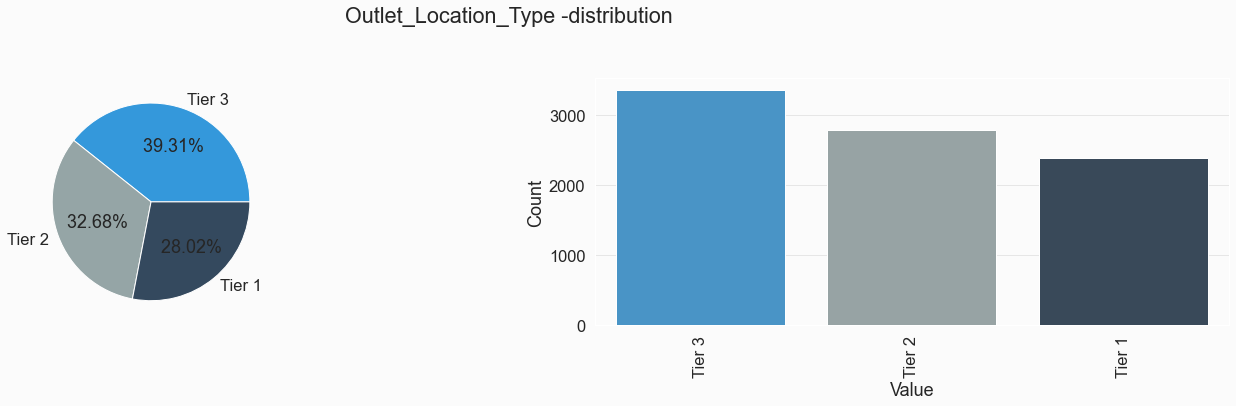

In [97]:
analyze_discrete_feature(df_train.Outlet_Location_Type)

<h4 style="background-color:#fbfbfb;font-family:serif;font-size:160%;">
    Most of the outlets are located in Tier3 location type.
    </h4>

## 11. Outlet_Type
Whether the outlet is just a grocery store or some sort of supermarket

Sample data:



0    Supermarket Type1
1    Supermarket Type2
2    Supermarket Type1
3        Grocery Store
4    Supermarket Type1
Name: Outlet_Type, dtype: object


Null value count :  0

Unique values:  ['Supermarket Type1', 'Supermarket Type2', 'Grocery Store', 'Supermarket Type3']

 Unique values count:  4

Value counts:
                Value  Count
0  Supermarket Type1   5577
1      Grocery Store   1083
2  Supermarket Type3    935
3  Supermarket Type2    928


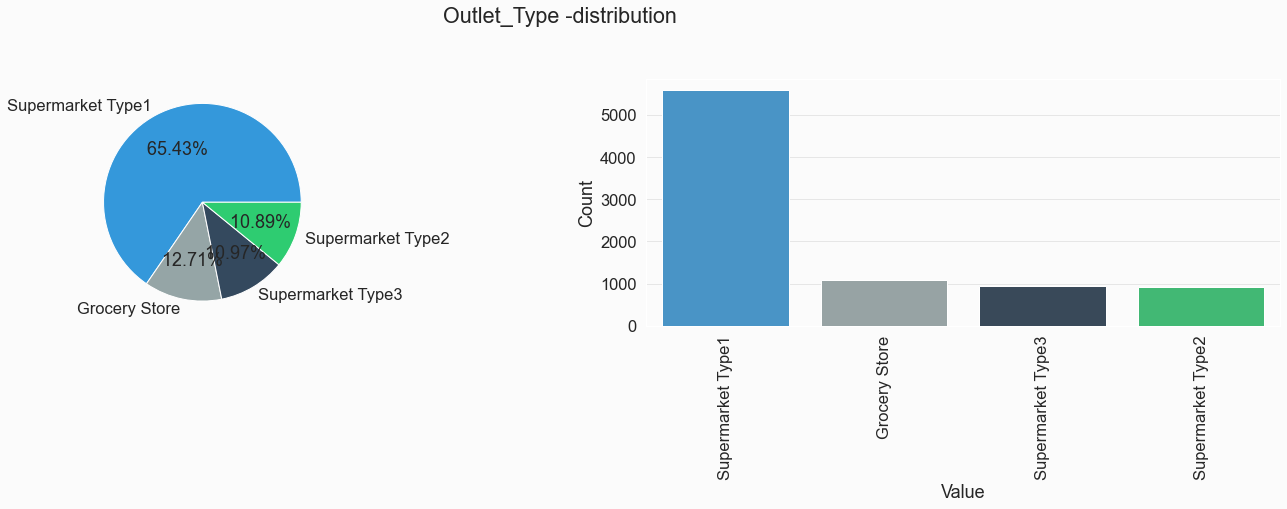

In [98]:
analyze_discrete_feature(df_train.Outlet_Type)

<h4 style="background-color:#fbfbfb;font-family:serif;font-size:160%;">
    65% Outlets are type of Supermarket type1.
    </h4>
    

## 12. Item_Outlet_Sales
Sales of the product in the particular store. This is the outcome variable to be predicted.

Sample data:
 0     9.30
1     5.92
2    17.50
3    19.20
4     8.93
Name: Item_Weight, dtype: float64

Null value count :  0

 count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

 Skewness : 1.1775306028542798 



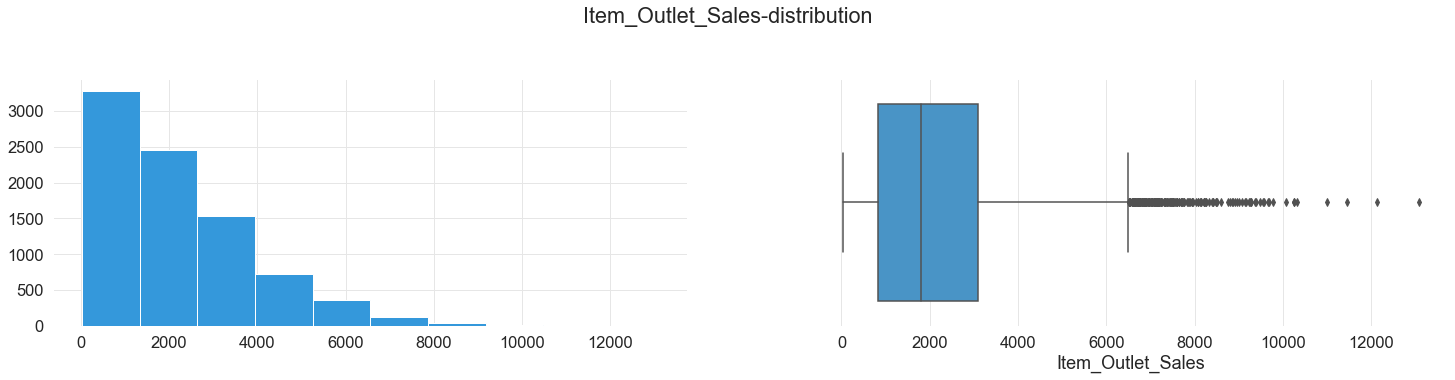

In [99]:
analyze_continuous_feature(df_train.Item_Outlet_Sales)

<h4 style="background-color:#fbfbfb;font-family:serif;font-size:160%;">
    Positively skewed.
    </h4>

## <center> Missing values treatment </center>

In [100]:
#Store the target feature for future use.
target = df_train.Item_Outlet_Sales

#Combining test and training data for imputing missing values.
df_total=df_train.drop("Item_Outlet_Sales", axis=1).copy()
 
#Changing the index of df_test, for creating a total dataframe by appending to training data frame.
start_index = df_train.index.max()+1
end_index = df_test.index.max()+1
#Storing test index retrieve data later.
new_index_list=list(range(start_index,start_index+end_index))

#Assigning new index, which is starting from end of training index.
df_test.index=new_index_list

#df_total=df_train + df_test
df_total=pd.concat([df_total,df_test],axis=0)
print (f"\nShape total data frame:{df_total.shape}\n")


Shape total data frame:(14204, 11)



In [101]:
#Print missing value counts
dummy = df_total.isnull().sum()
dummy=dummy.to_frame().reset_index()
dummy.rename(columns={0:"Count","index":"Feature"},inplace=True)
print ("\n Missing value counts: \n")
display(dummy.query('Count != 0'))


 Missing value counts: 



,Feature,Count
1,Item_Weight,2439
8,Outlet_Size,4016


In [102]:
#Group data based on Item_Type and find the mean value of Item_Weight for each size.
grouped=df_total.groupby("Item_Type")
mean_weight_values=grouped.Item_Weight.aggregate("mean")

#Group Outlet_Type and find Mod value of Outlet_Size for each group.
grouped=df_total.groupby("Outlet_Type")
mean_outlet_size=grouped.Outlet_Size.aggregate(pd.Series.mode)

In [103]:
#Fill the missing values with aggregate values.

for item in mean_weight_values.index:
    mean_weight = mean_weight_values[item]
    #print (f"Mean weight for {item} is {mean_weight}")
    item_weight=df_total[df_total['Item_Type']==item]['Item_Weight']
    item_weight.fillna(mean_weight,inplace=True)
    df_total.loc[item_weight.index,"Item_Weight"]=item_weight.values
    
for typ in mean_outlet_size.index:
    mean_size = mean_outlet_size[typ]
    outlet_size=df_total[df_total['Outlet_Type']==typ]['Outlet_Size']
    outlet_size.fillna(mean_size,inplace=True)
    df_total.loc[outlet_size.index,"Outlet_Size"]=outlet_size.values

In [104]:
#Print missing value counts
dummy = df_total.isnull().sum()
dummy=dummy.to_frame().reset_index()
dummy.rename(columns={0:"Count","index":"Feature"},inplace=True)
print ("\n Missing value counts: \n")
display(dummy.query('Count != 0'))


 Missing value counts: 



,Feature,Count


In [105]:
#Remove duplicate values for Item fat content.
df_total['Item_Fat_Content'].replace('reg','Regular',inplace=True)
df_total['Item_Fat_Content'].replace(['LF','low fat'],'Low Fat',inplace=True)
#save index list for later use
train_index=df_train.index
test_index=new_index_list
#Retrieve mofified train and test data
df_test=df_total.loc[new_index_list]
df_train=df_total.loc[df_train.index]
df_train["Item_Outlet_Sales"]=target

## <center>Feature relations in training dataset</center>

## 1. Item_Fat_Content, Item_Type

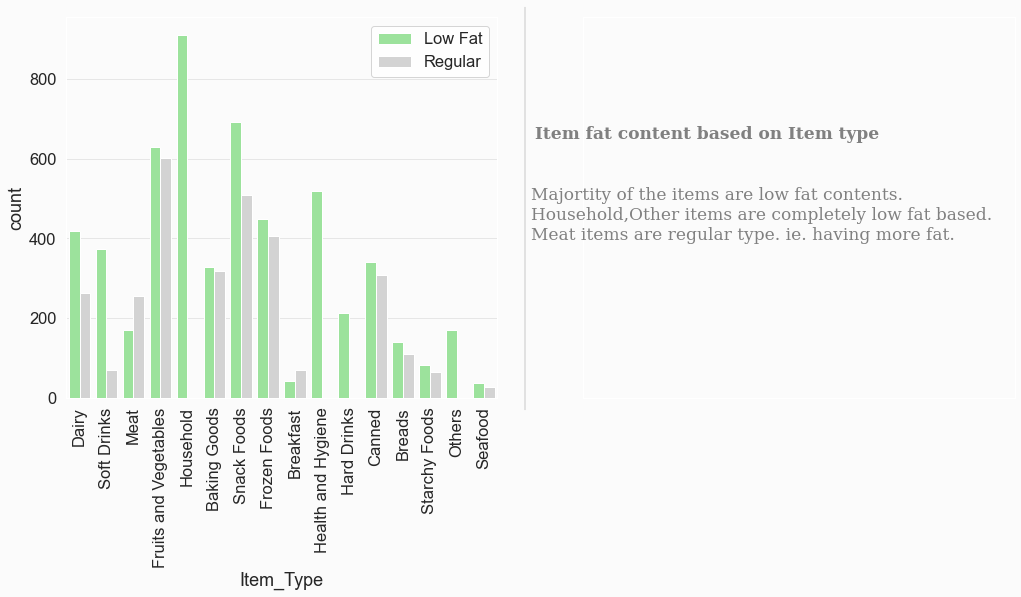

In [106]:
#Visualization
fig=plt.figure(figsize=(17,7));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)

#Plot the countplot
sns.countplot(data=df_train,x="Item_Type",hue="Item_Fat_Content",palette=['lightgreen','lightgrey'],ax=ax0);
ax0.legend(loc="upper right")

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    

#Draw line in the middle    
l1= lines.Line2D([0.5,0.5],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.47,
        y=0.6,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Item fat content based on Item type
        ''')
#text content
fig.text(x=0.47,
        y=0.4,
        fontweight='light',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Majortity of the items are low fat contents.
        Household,Other items are completely low fat based.
        Meat items are regular type. ie. having more fat.
        '''        )
plt.show()

## 2. Item_Visibility,Outlet_Size,Item_Outlet_Sales
Is there any relation between item display area and sales?

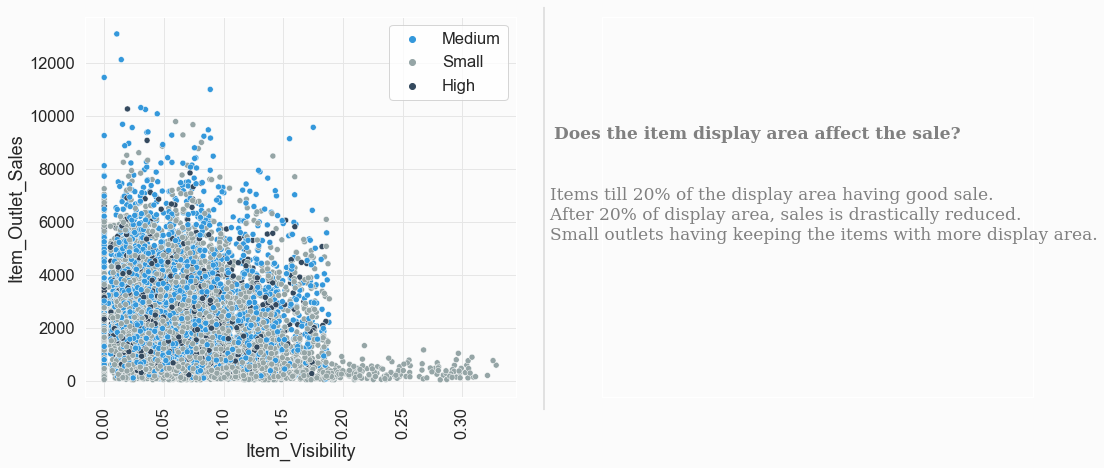

In [107]:
#Visualization
fig=plt.figure(figsize=(17,7));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)

#Plot the countplot
sns.scatterplot(data=df_train,x="Item_Visibility",y="Item_Outlet_Sales",hue="Outlet_Size",ax=ax0);
ax0.legend(loc="upper right")

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    

#Draw line in the middle    
l1= lines.Line2D([0.5,0.5],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.47,
        y=0.6,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Does the item display area affect the sale?
        ''')
#text content
fig.text(x=0.47,
        y=0.4,
        fontweight='light',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Items till 20% of the display area having good sale.
        After 20% of display area, sales is drastically reduced.
        Small outlets having keeping the items with more display area.
        '''        )
plt.show()

## 3. Item type, Item sales
Which Item type having more sales?

In [108]:
df=df_train.loc[:,["Item_Type","Item_Outlet_Sales"]]

#df_sale=df.groupby("Item_Type",as_index=False).agg({'Item_Outlet_Sale':sum})
df_sale=df.groupby("Item_Type").agg({'Item_Outlet_Sales':sum})

df_sale.sort_values("Item_Outlet_Sales",inplace=True,ascending=False)
#display(df_sale)

#Cumilative percent.
cum_percent=df_sale.Item_Outlet_Sales.cumsum()/df_sale.Item_Outlet_Sales.sum()*100
#display(cum_percent)

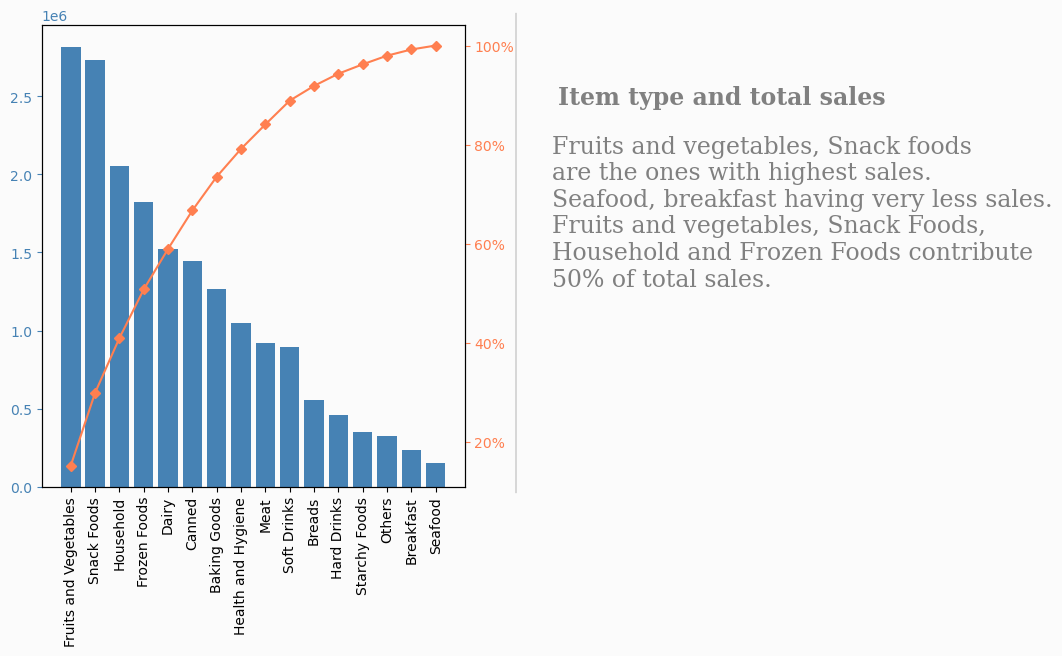

In [109]:
sns.reset_defaults()

#Visualization
fig=plt.figure(figsize=(12,6));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.tick_params(left=False,bottom=False)

#Plot the barplot
ax0.bar(df_sale.index,df_sale.Item_Outlet_Sales,color='steelblue');
ax0.tick_params(axis='y', colors='steelblue')

ax2=ax0.twinx()
ax2.plot(cum_percent.index,cum_percent.values,color='coral',marker='D',ms=5)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.tick_params(axis='y',colors='coral')

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    
#Draw line in the middle    
l1= lines.Line2D([0.52,0.52],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.5,
        y=0.7,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Item type and total sales
        ''')
#text content
fig.text(x=0.5,
        y=0.4,
        fontweight='light',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Fruits and vegetables, Snack foods 
        are the ones with highest sales.
        Seafood, breakfast having very less sales.
        Fruits and vegetables, Snack Foods,
        Household and Frozen Foods contribute
        50% of total sales.
        ''')
plt.show()

## 4. Outlet type, Outlet location

In [110]:
#Value counts for the combination of location type and outlet type.
df=df_train.loc[:,["Outlet_Location_Type","Outlet_Type"]].value_counts().reset_index()
df.rename(columns={0:'Count'},inplace=True)
display(df)

,Outlet_Location_Type,Outlet_Type,Count
0,Tier 2,Supermarket Type1,2785
1,Tier 1,Supermarket Type1,1860
2,Tier 3,Supermarket Type3,935
3,Tier 3,Supermarket Type1,932
4,Tier 3,Supermarket Type2,928
5,Tier 3,Grocery Store,555
6,Tier 1,Grocery Store,528


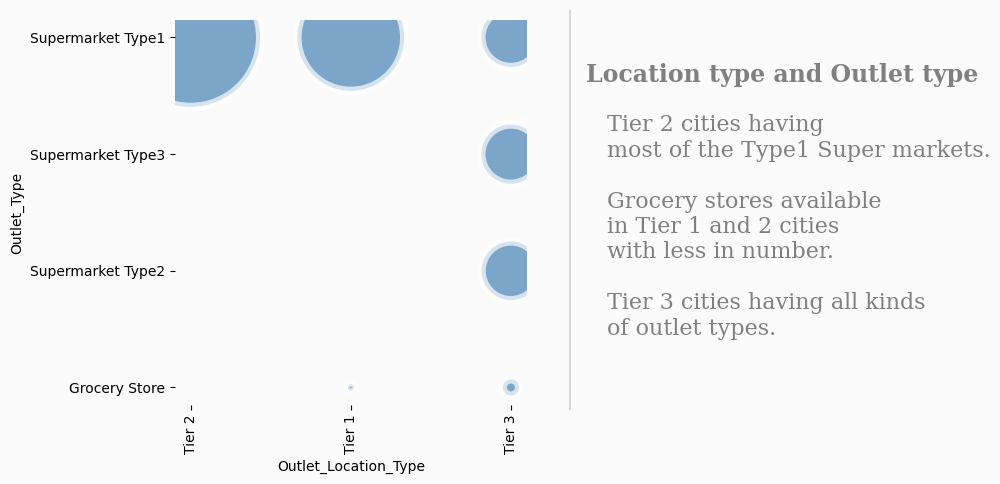

In [111]:
sns.reset_defaults()

#Visualization
fig=plt.figure(figsize=(10,5));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax0.spines["bottom"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.tick_params(left=False,bottom=False)

#Plot the barplot
sns.scatterplot(data=df,x="Outlet_Location_Type",y="Outlet_Type", size="Count",sizes=(20,10000),color='steelblue',alpha=0.7,legend=False,linewidth=6,ax=ax0);

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    
#Draw line in the middle    
l1= lines.Line2D([0.52,0.52],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.47,
        y=0.7,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Location type and Outlet type
        ''')
#text content
fig.text(x=0.5,
        y=0.2,
        fontweight='light',
        fontfamily='serif',
        fontsize=16,
        color='grey',
        s='''
        Tier 2 cities having 
        most of the Type1 Super markets.
        
        Grocery stores available 
        in Tier 1 and 2 cities 
        with less in number.
        
        Tier 3 cities having all kinds 
        of outlet types.
        ''')
plt.show()

## 5. Location type and Item_Outlet_Sales

In [112]:
df=df_train.loc[:,["Outlet_Location_Type","Item_Outlet_Sales"]]
#Find total of Item_Outlet_Sale based on Location type
df=df.groupby('Outlet_Location_Type').agg({"Item_Outlet_Sales":sum})
df.reset_index(inplace=True)

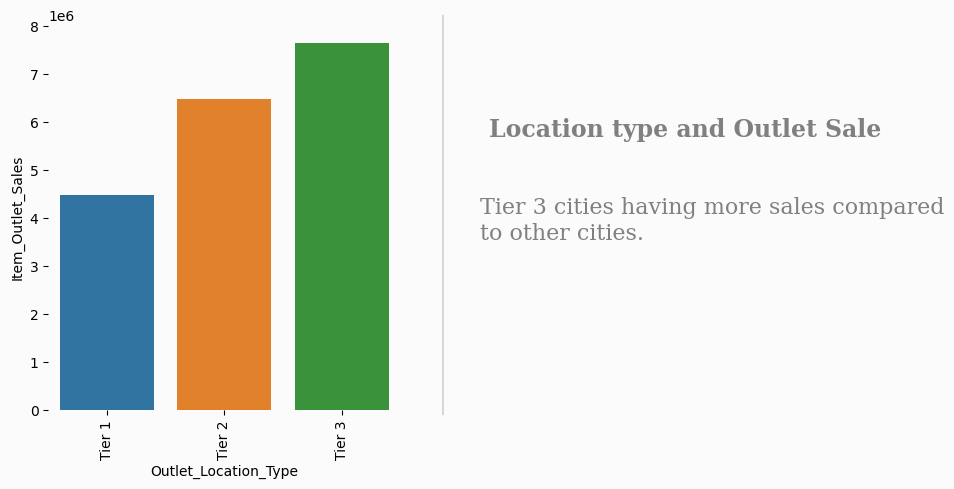

In [113]:
sns.reset_defaults()

#Visualization
fig=plt.figure(figsize=(10,5));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax0.spines["bottom"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.tick_params(left=False,bottom=False)

#Plot the barplot
sns.barplot(data=df,x='Outlet_Location_Type',y='Item_Outlet_Sales',estimator=sum,ax=ax0)

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    
#Draw line in the middle    
l1= lines.Line2D([0.52,0.52],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.5,
        y=0.6,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Location type and Outlet Sale
        ''')
#text content
fig.text(x=0.5,
        y=0.4,
        fontweight='light',
        fontfamily='serif',
        fontsize=16,
        color='grey',
        s='''
        Tier 3 cities having more sales compared
        to other cities.
        ''')
plt.show()

## 6. Outlet types based on established year

In [114]:
df=df_train.loc[:,["Outlet_Type","Outlet_Establishment_Year"]]
df=df.value_counts().to_frame().reset_index()
df.rename(columns={0:"Count"},inplace=True)
display(df)

,Outlet_Type,Outlet_Establishment_Year,Count
0,Supermarket Type3,1985,935
1,Supermarket Type1,1987,932
2,Supermarket Type1,2004,930
3,Supermarket Type1,1999,930
4,Supermarket Type1,1997,930
5,Supermarket Type1,2002,929
6,Supermarket Type2,2009,928
7,Supermarket Type1,2007,926
8,Grocery Store,1998,555
9,Grocery Store,1985,528


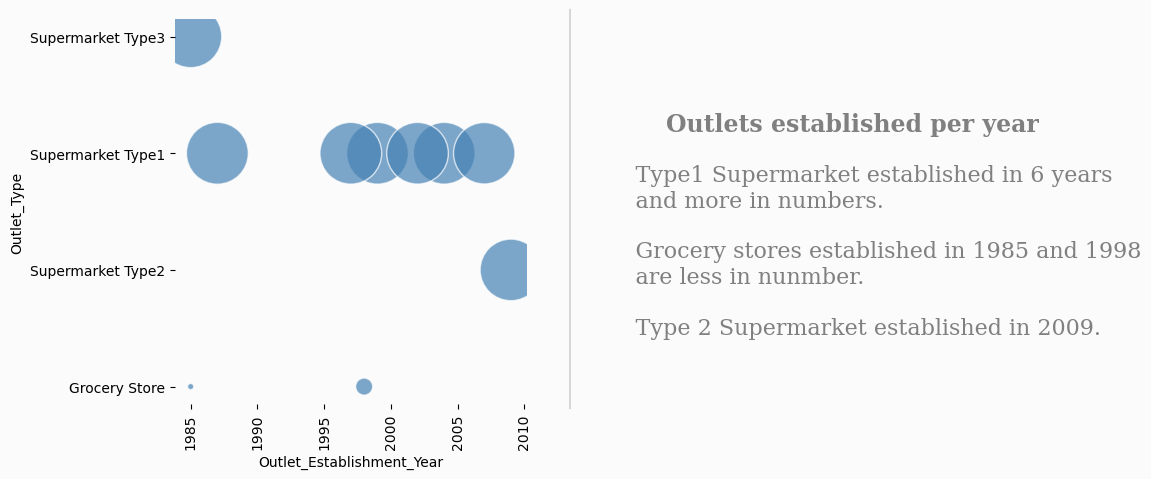

In [115]:
sns.reset_defaults()

#Visualization
fig=plt.figure(figsize=(10,5));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax0.spines["bottom"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.tick_params(left=False,bottom=False)

#Plot the barplot
sns.scatterplot(data=df,x="Outlet_Establishment_Year",y="Outlet_Type",size="Count",sizes=(20,2000),legend=False,color='steelblue',alpha=0.7,linewidth=1,ax=ax0);

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    
#Draw line in the middle    
l1= lines.Line2D([0.52,0.52],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.55,
        y=0.6,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Outlets established per year
        ''')
#text content
fig.text(x=0.5,
        y=0.2,
        fontweight='light',
        fontfamily='serif',
        fontsize=16,
        color='grey',
        s='''
            Type1 Supermarket established in 6 years
            and more in numbers.
            
            Grocery stores established in 1985 and 1998
            are less in nunmber.
            
            Type 2 Supermarket established in 2009.
        ''')
plt.show()

## 7. Outlet Identifier, Item Outlet Sale
Which outlet having maximum sales?

In [116]:
df=df_train.loc[:,["Outlet_Identifier","Item_Outlet_Sales"]]
df=df.groupby("Outlet_Identifier").agg({"Item_Outlet_Sales":sum}).reset_index()
df.sort_values("Item_Outlet_Sales",ascending=False,inplace=True)

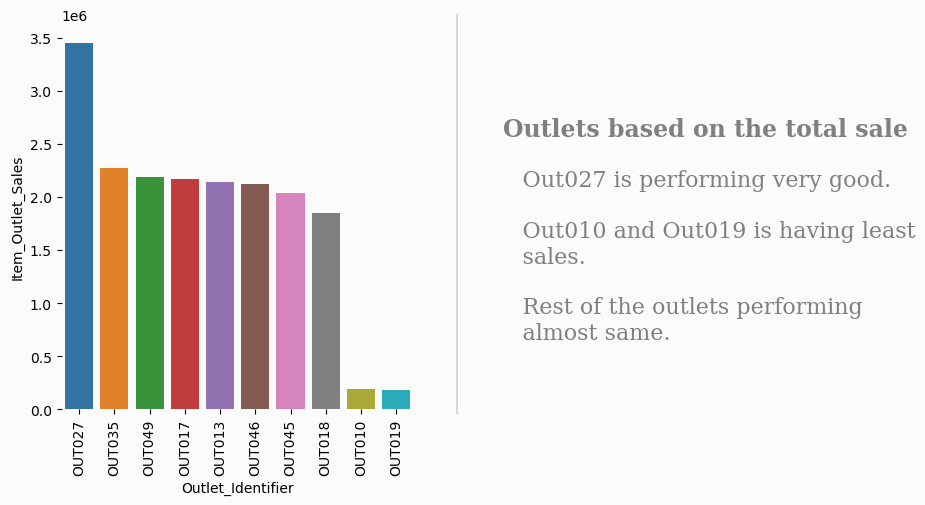

In [117]:
sns.reset_defaults()

#Visualization
fig=plt.figure(figsize=(10,5));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax0.spines["bottom"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.tick_params(left=False,bottom=False)

#Plot the barplot
sns.barplot(data=df,x="Outlet_Identifier",y="Item_Outlet_Sales",ax=ax0)

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    
#Draw line in the middle    
l1= lines.Line2D([0.52,0.52],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#heading content
fig.text(x=0.5,
        y=0.6,
        fontweight='bold',
        fontfamily='serif',
        fontsize=17,
        color='grey',
        s='''
        Outlets based on the total sale
        ''')
#text content
fig.text(x=0.5,
        y=0.2,
        fontweight='light',
        fontfamily='serif',
        fontsize=16,
        color='grey',
        s='''
            Out027 is performing very good.
            
            Out010 and Out019 is having least
            sales.
            
            Rest of the outlets performing 
            almost same.
        ''')
plt.show()

## <center> Data cleaning for model preparation</center>

In [118]:
#working on df_total data frame, as its containing train and test data.
#This will help in considering data from train and test file equally.

lbl_encoder=LabelEncoder()
#Item_Identifier - is a item identifier, having more unique values.Hence dropping it.
#df_total.drop("Item_Identifier",inplace=True,axis=1)
#df_total["Item_Identifier"] = lbl_encoder.fit_transform(df_total['Item_Identifier'])

#df_total["Outlet_Identifier"] = lbl_encoder.fit_transform(df_total['Outlet_Identifier'])

#df['Item_Type'] = lbl_encoder.fit_transform(df_total['Item_Type'])


#Fat content contains binary values. So label encode it.
df_total['Item_Fat_Content'] = lbl_encoder.fit_transform(df_total['Item_Fat_Content'])

#Outlet_Size having categorical data with certain order. So we can encode it based on order.
#Outlet_Size mapping,  based on size. 
keys=['Small','Medium','High' ]
values=[1,2,3]
mapping = [{
    'col':'Outlet_Size',
    'mapping':dict(zip(keys,values))}]
ord_encoder=OrdinalEncoder(cols='Outlet_Size',mapping=mapping)
df_total.Outlet_Size=ord_encoder.fit_transform(df_total.Outlet_Size)

#Locatio type also having data having certain order.
#Location type mapping, based on location type
keys=['Tier 1', 'Tier 2', 'Tier 3']
values=[1,2,3]
mapping = [{
    'col':'Outlet_Location_Type',
    'mapping':dict(zip(keys,values))}]
ord_encoder=OrdinalEncoder(cols='Outlet_Location_Type',mapping=mapping)
df_total.Outlet_Location_Type=ord_encoder.fit_transform(df_total.Outlet_Location_Type)

#Outlet type also having data in certain order.
#Outlet type mapping, based on Outlet type
keys=['Grocery Store','Supermarket Type1', 'Supermarket Type2', 'Supermarket Type3']
values=[1,2,3,4]
mapping = [{
    'col':'Outlet_Type',
    'mapping':dict(zip(keys,values))}]
ord_encoder=OrdinalEncoder(cols='Outlet_Type',mapping=mapping)
df_total.Outlet_Type=ord_encoder.fit_transform(df_total.Outlet_Type)

#Item_Type and Outlet_Identifier doesn't follow any order. So encode without any order.   
df_total=pd.get_dummies(df_total)
display (df_total.head())

print(f"\n Updated fetature names: \n {df_total.columns}")

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier_DRA12,Item_Identifier_DRA24,...,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,9.30,0,0.016047,249.8092,1999,2,1,2,0,0,...,0,0,0,0,0,0,0,0,0,1
1,5.92,1,0.019278,48.2692,2009,2,3,3,0,0,...,0,0,0,1,0,0,0,0,0,0
2,17.50,0,0.016760,141.6180,1999,2,1,2,0,0,...,0,0,0,0,0,0,0,0,0,1
3,19.20,1,0.000000,182.0950,1998,1,3,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,8.93,0,0.000000,53.8614,1987,3,3,2,0,0,...,0,1,0,0,0,0,0,0,0,0



 Updated fetature names: 
 Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Identifier_DRA12', 'Item_Identifier_DRA24',
       ...
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049'],
      dtype='object', length=1593)


In [119]:
#Retrieve data to train and test data frames
df_train = df_total.loc[train_index]
df_test = df_total.loc[test_index]
print (f"\nTrain data shape: {df_train.shape} \nTest data shape: {df_test.shape}\n")


Train data shape: (8523, 1593) 
Test data shape: (5681, 1593)



In [120]:
#Get the correation dataframe.
df=df_train.loc[:,['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type']]

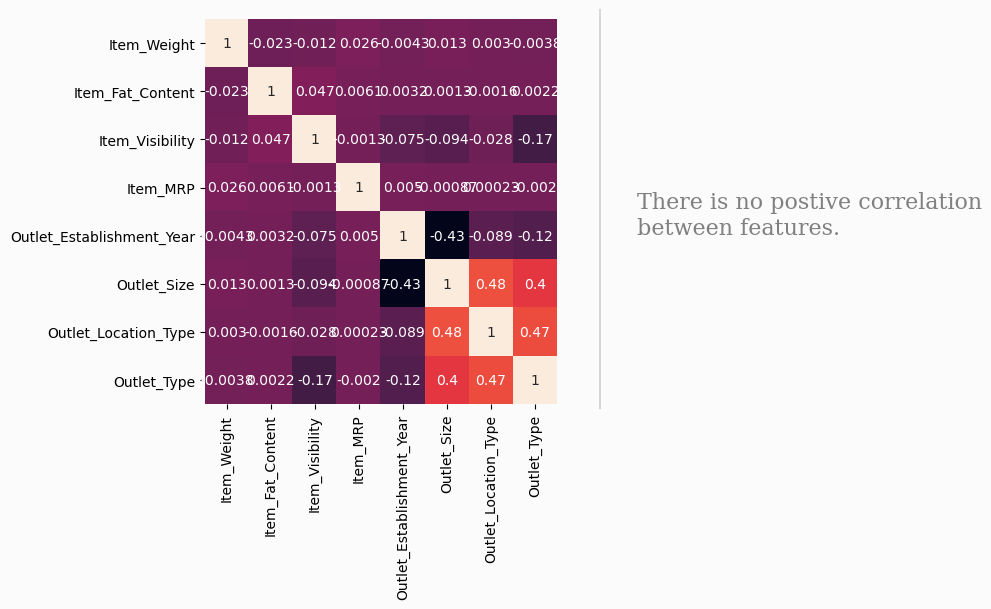

In [121]:
sns.reset_defaults()

#Visualization
fig=plt.figure(figsize=(10,5));

ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax0.spines["bottom"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.tick_params(left=False,bottom=False)

#Plot the barplot
sns.heatmap(df.corr(),annot=True,cbar=False,ax=ax0);

#rotating the ticklabels in x axis
for tick in ax0.get_xticklabels():
    tick.set_rotation(90)
    
#Draw line in the middle    
l1= lines.Line2D([0.52,0.52],[0.1, 0.9],color='black',lw=0.2,transform=fig.transFigure)
fig.lines.extend([l1])

#text content
fig.text(x=0.5,
        y=0.4,
        fontweight='light',
        fontfamily='serif',
        fontsize=16,
        color='grey',
        s='''
        There is no postive correlation
        between features.
        ''')
plt.show()

## Target feature transformation

In [122]:
print ("Target feature skewnes : ", target.skew())
print (f"Target Square Root Skewness: {np.sqrt(target).skew()}")
print (f"Target Log Skewness: {np.log(target).skew()}")
box_cox_target = pd.Series(stats.boxcox(target)[0])
box_cox_param = stats.boxcox(target)[1]
print (f"Target Box Cox Skewness: {box_cox_target.skew()}")

Target feature skewnes :  1.1775306028542798
Target Square Root Skewness: 0.23467599347099247
Target Log Skewness: -0.887753343209305
Target Box Cox Skewness: -0.0749781187485208


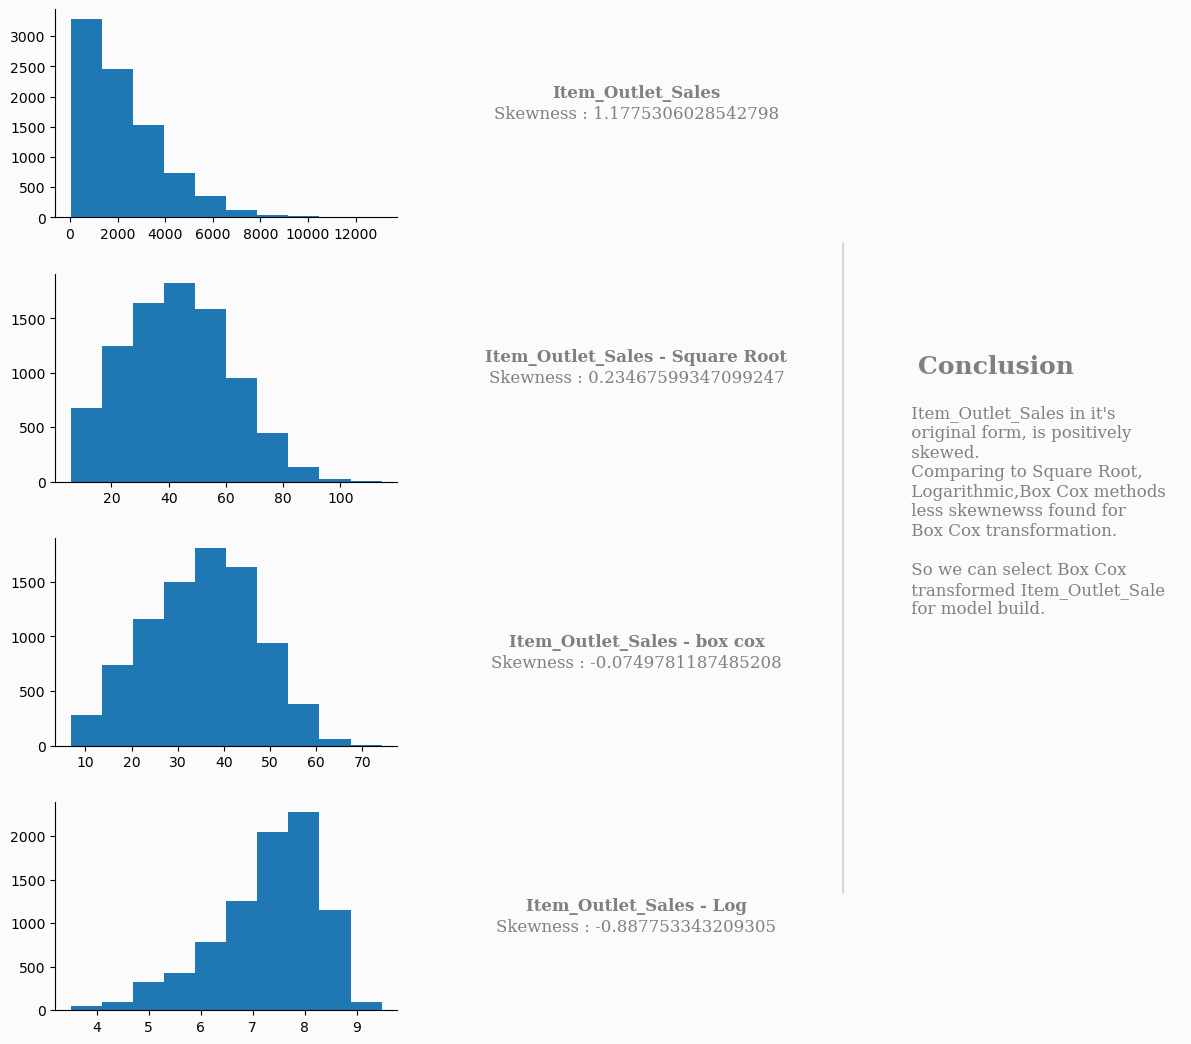

In [123]:
sns.reset_defaults()
fig=plt.figure(figsize=(15,13));
gs=fig.add_gridspec(4,3)
gs.update(wspace=0.2,hspace=0.27)

#Create subplots
ax00=fig.add_subplot(gs[0,0]);
ax01=fig.add_subplot(gs[0,1]);
ax10=fig.add_subplot(gs[1,0]);
ax11=fig.add_subplot(gs[1,1]);
ax20=fig.add_subplot(gs[2,0]);
ax21=fig.add_subplot(gs[2,1]);
ax30=fig.add_subplot(gs[3,0]);
ax31=fig.add_subplot(gs[3,1]);

#Setting the background color for entire figure as well as graph plots
background_color="#fbfbfb"
fig.patch.set_facecolor(background_color)

for ax in fig.get_axes():
    ax.set_facecolor(background_color)         #set axis background color
    for position in ["top","right"]:
        ax.spines[position].set_visible(False) #remove top and right side axis margins

for ax in [ax01,ax11,ax21,ax31]:               #Middle column axis for text.
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(left=False,right=False,top=False,bottom=False)
    for position in ["left","bottom"]:
        ax.spines[position].set_visible(False)

#Put actual graphs
ax00.hist(target);
ax10.hist(np.sqrt(target));
ax20.hist(box_cox_target);
ax30.hist(np.log(target));
    
ax01.text(x=0.5,
          y=0.6,
          s="Item_Outlet_Sales",
          horizontalalignment='center',
          verticalalignment='center',
          fontsize=12,
          fontweight='bold',
          fontfamily='serif',
          color='grey'
         )
ax01.text(x=0.5,
          y=0.5,
          s="Skewness : 1.1775306028542798",
          horizontalalignment='center',
          verticalalignment='center',
          fontsize=12,
          fontweight='light',
          fontfamily='serif',
          color='grey'
         )
ax11.text(x=0.5,
          y=0.6,
          s="Item_Outlet_Sales - Square Root",
          horizontalalignment='center',
          verticalalignment='center',
          fontsize=12,
          fontweight='bold',
          fontfamily='serif',
          color='grey'
         )
ax11.text(x=0.5,
          y=0.5,
          s="Skewness : 0.23467599347099247",
          horizontalalignment='center',
          verticalalignment='center',
          fontsize=12,
          fontweight='light',
          fontfamily='serif',
          color='grey'
         )
ax21.text(x=0.5,
          y=0.5,
          s="Item_Outlet_Sales - box cox",
          horizontalalignment='center',
          verticalalignment='center',
          fontsize=12,
          fontweight='bold',
          fontfamily='serif',
          color='grey'
         )
ax21.text(x=0.5,
          y=0.4,
          s="Skewness : -0.0749781187485208",
          horizontalalignment='center',
          verticalalignment='center',
          fontsize=12,
          fontweight='light',
          fontfamily='serif',
          color='grey'
         )
ax31.text(x=0.5,
          y=0.5,
          s="Item_Outlet_Sales - Log",
          horizontalalignment='center',
          verticalalignment='center',
          fontsize=12,
          fontweight='bold',
          fontfamily='serif',
          color='grey'
         )
ax31.text(x=0.5,
          y=0.4,
          s="Skewness : -0.887753343209305",
          horizontalalignment='center',
          verticalalignment='center',
          fontsize=12,
          fontweight='light',
          fontfamily='serif',
          color='grey'
         )

#Draw line
l1=lines.Line2D([0.65,0.65],[0.2,0.7], transform=fig.transFigure, figure=fig, color='black',lw=0.2)
fig.lines.extend([l1])

fig.text(x=0.7,y=.6,s="Conclusion",
        fontsize=18,
        fontweight='bold',
        fontfamily='serif',
        color='grey')

fig.text(x=0.65,y=0.4,
         s='''
             Item_Outlet_Sales in it's
             original form, is positively
             skewed.
             Comparing to Square Root,
             Logarithmic,Box Cox methods
             less skewnewss found for
             Box Cox transformation.
             
             So we can select Box Cox
             transformed Item_Outlet_Sale
             for model build.                          
         ''',
        fontsize=12,
        fontweight='light',
        fontfamily='serif',
        color='grey')

plt.show()


In [124]:
#target = inv_boxcox(box_cox_target,box_cox_param)
#Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.inv_boxcox.html

Negative Correlated fields:

['Item_Identifier_FDG12', 'Item_Identifier_FDF26', 'Item_Identifier_FDZ52', 'Item_Identifier_NCS30', 'Item_Identifier_FDV52', 'Item_Identifier_FDX08', 'Item_Identifier_FDH35', 'Item_Identifier_FDH57', 'Item_Identifier_DRA24', 'Item_Identifier_FDW20', 'Item_Type_Dairy', 'Item_Identifier_FDW21', 'Item_Identifier_FDS23', 'Item_Identifier_FDV50', 'Item_Identifier_FDG58', 'Item_Identifier_NCG42', 'Item_Identifier_NCJ43', 'Item_Identifier_NCR41', 'Item_Identifier_FDW58', 'Item_Identifier_DRD24', 'Item_Identifier_DRL23', 'Item_Identifier_FDE08', 'Item_Identifier_FDG02', 'Item_Identifier_FDV21', 'Item_Identifier_NCH07', 'Item_Identifier_FDH26', 'Item_Identifier_FDW40', 'Item_Identifier_DRZ11', 'Item_Identifier_FDF16', 'Item_Identifier_FDR58', 'Item_Identifier_FDH38', 'Item_Identifier_FDX37', 'Item_Identifier_FDV13', 'Item_Identifier_FDB12', 'Item_Identifier_NCV05', 'Item_Identifier_FDO50', 'Item_Identifier_FDF32', 'Item_Identifier_NCQ29', 'Item_Identifier_NCB54', '

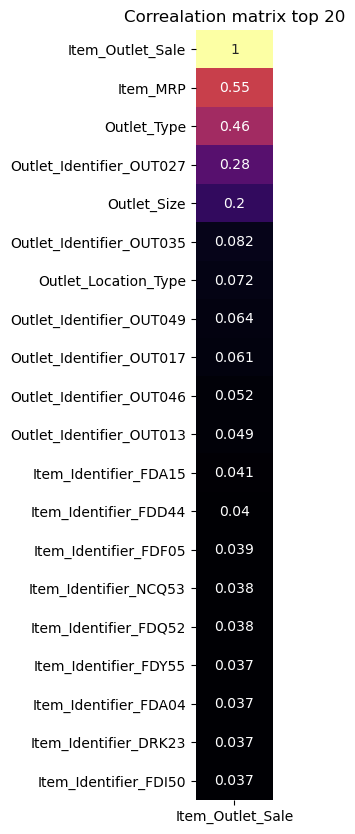

In [125]:
df=df_train.copy()
df['Item_Outlet_Sale']=box_cox_target
corr_matrix = df.corr()
corr_matrix=pd.DataFrame(corr_matrix['Item_Outlet_Sale']).sort_values('Item_Outlet_Sale',ascending=False)
negative_corr_flds=corr_matrix[corr_matrix["Item_Outlet_Sale"]<= 0].index.tolist()
print ("Negative Correlated fields:\n")
print(negative_corr_flds)
print("\n")

plt.figure(figsize=(1,10))
sns.heatmap(corr_matrix.head(20),cmap='inferno',annot=True,cbar=False,).set_title("Correalation matrix top 20");
plt.show()

## <center> Model building </center>

In [126]:
#Function for providing generalized results for regression model
def evaluate_model(model,x_train,y_train,x_test,y_test):
    model.fit(x_train,y_train)
    model_name=model.__class__.__name__
    train_score=model.score(x_train,y_train)
    test_score=model.score(x_test,y_test)
    print (f"Training score: {train_score} \nTesting score: {test_score}")
    
    y_pred=model.predict(x_test)
    print("Prediction completed")
    df=pd.DataFrame({"Actual": y_test,
                     "Predicted":y_pred})
    
    #Apply inverse box cox to retrieve original target results
    df=inv_boxcox(df,box_cox_param)
    #Finding the difference between original and predicted
    df["difference"]=df.Predicted-df.Actual
    df.reset_index(inplace=True)
    #Plot actual vs predicted
    plt.figure(figsize=(10,5));
    sns.scatterplot(data=df,x="index",y="Actual",color='grey',label=["Actual"]).set_facecolor(background_color);
    sns.lineplot(data=df,x="index",y="Predicted",color='salmon',label=["Predicted"]);
    plt.legend(loc="right",bbox_to_anchor=(1.1,1));
    plt.title(model_name+" -Actual vs Predicted");
    plt.show()
    print ("Sample comparison file for actual and predicted target feature:")
    display(df.head())
    return model

In [127]:
#General data frame and function for stroing and comparing model results.
df_model_results=pd.DataFrame(columns=["ModelName","TrainScore"])

def store_model_results(modl_name,train_score):
    global df_model_results
    row_loc=df_model_results.shape[0]+1
    df_model_results.loc[row_loc,["ModelName","TrainScore"]]=[modl_name,train_score]

In [128]:
#Run each model and show the combined results.
def show_model_scores(x,y):
    global df_model_results
    df_model_results=df_model_results.iloc[0:0] #reset display dataframe
    for model in  [LinearRegression(),
                   Lasso(),Ridge(),
                   ElasticNet(),
                   XGBRegressor()]:
        store_model_results(model.__class__.__name__, cross_val_score(model,x,y,cv=3).mean())
    df_model_results.sort_values("TrainScore",ascending=False,inplace=True)
    display(df_model_results)
    display(HTML('Selected model : <b>' + df_model_results.head(1)['ModelName'].values[0] + '</b>'))
    

In [129]:
#Store x and y values for model usage.
x=df_train
y=box_cox_target
show_model_scores(x,y)

,ModelName,TrainScore
5,XGBRegressor,0.676328
3,Ridge,0.633654
2,Lasso,0.509825
4,ElasticNet,0.481167
1,LinearRegression,-4.8272e+09


In [130]:
#Create new feature 'Outlet_Age' from Outlet_Establishment_Year
#Drop the feature - Outlet_Establishment_Year
current_year=2021  #Hardcoded for value for reference
df_total['Outlet_Age']=current_year-df_total['Outlet_Establishment_Year']
df_total.drop("Outlet_Establishment_Year",inplace=True,axis=1)

df_train=df_total.loc[train_index]
df_test=df_total.loc[test_index]
x=df_train

show_model_scores(x,y)

,ModelName,TrainScore
5,XGBRegressor,0.676334
3,Ridge,0.633654
2,Lasso,0.509825
4,ElasticNet,0.481167
1,LinearRegression,-2.97202e+17


In [131]:
#Standardizing features doesn't have any impact on model scores. Hence commenting below section

#df_total['Item_MRP'] = standardize(df_total.Item_MRP)
#df_total.Item_Weight = standardize(df_total.Item_Weight)
#df_total.Outlet_Age  = standardize(df_total.Outlet_Age)

#df_train=df_total.loc[train_index]
#df_test=df_total.loc[test_index]
#x=df_train

# show_model_scores(x,y)

In [132]:
#Remove negative correlated features and check the model performance
df_total.drop(negative_corr_flds,axis=1,inplace=True)
df_train=df_total.loc[train_index]
df_test=df_total.loc[test_index]
x=df_train

show_model_scores(x,y)

,ModelName,TrainScore
5,XGBRegressor,0.677337
3,Ridge,0.654055
2,Lasso,0.509825
4,ElasticNet,0.470335
1,LinearRegression,-7.18527e+18


In [133]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=1)

Training score: 0.774506465869167 
Testing score: 0.6804110503217267
Prediction completed


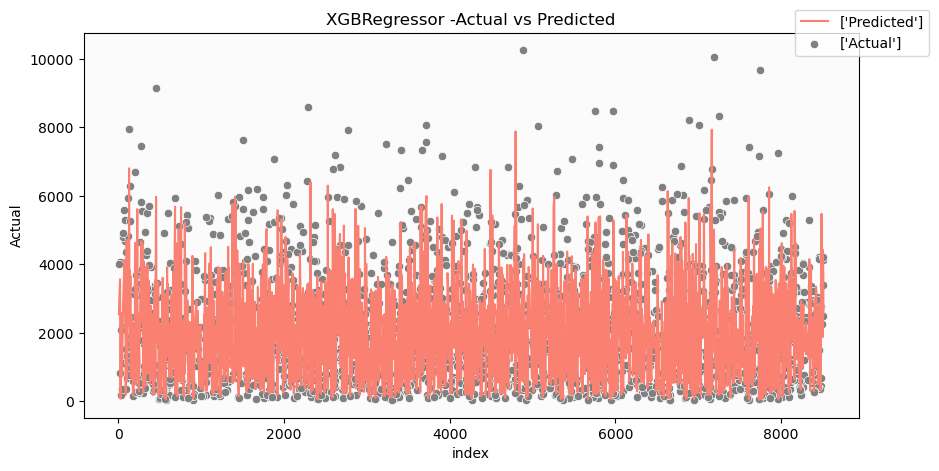

Sample comparison file for actual and predicted target feature:


,index,Actual,Predicted,difference
0,1070,952.7598,565.537207,-387.222593
1,6305,1133.8574,1150.964673,17.107273
2,8504,4138.6128,4427.598891,288.986091
3,5562,1657.1762,1344.503627,-312.672573
4,1410,679.1160,598.202544,-80.913456


In [134]:
selected_model=evaluate_model(XGBRegressor(),
                          x_train,
                          y_train,
                          x_test,
                          y_test)

In [135]:
param_tuning={
    'learning_rate' : [0.01,0.1],
    'max_depth' : [3,5,7,10],
    'min_child_weight' : [1,3,5],
    'subsample' : [0.5,0.7],
    'colsample_bytree' : [0.5,0.7],
    'n_estimators' : [100,200,300],
    'objective' : ['reg:squarederror']
}

In [136]:
gsearch = GridSearchCV (estimator = XGBRegressor(),
                       param_grid = param_tuning,
                       cv = 2,
                       n_jobs= -1,
                       verbose = 1)

In [137]:
gsearch.fit(x,y)

Fitting 2 folds for each of 288 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 39.5min finished


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [138]:
gsearch.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [139]:
selected_model=gsearch.best_estimator_

Training score: 0.7115527159094119 
Testing score: 0.7023568232515688
Prediction completed


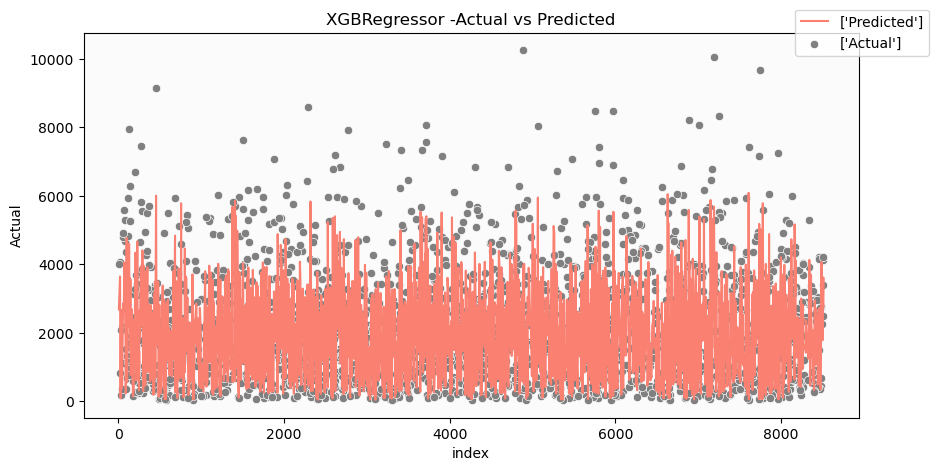

Sample comparison file for actual and predicted target feature:


,index,Actual,Predicted,difference
0,1070,952.7598,617.449086,-335.310714
1,6305,1133.8574,1216.882061,83.024661
2,8504,4138.6128,2684.844839,-1453.767961
3,5562,1657.1762,1322.454526,-334.721674
4,1410,679.1160,594.082375,-85.033625


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [140]:
evaluate_model(selected_model,
                          x_train,
                          y_train,
                          x_test,
                          y_test)

Ref: https://www.kaggle.com/felipefiorini/xgboost-hyper-parameter-tuning

## <center> Test file prediction </center>

In [141]:
x=df_test
y=selected_model.predict(x)
y=inv_boxcox(y,box_cox_param)

In [142]:
df_submission = pd.read_csv('test.csv',usecols=['Item_Identifier','Outlet_Identifier'])
df_submission['Item_Outlet_Sales']=pd.Series(y)
display(df_submission)

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1350.437134
1,FDW14,OUT017,1309.404541
2,NCN55,OUT010,667.740845
3,FDQ58,OUT017,2275.078369
4,FDY38,OUT027,5501.409668
...,...,...,...
5676,FDB58,OUT046,2026.932129
5677,FDD47,OUT018,2289.084229
5678,NCO17,OUT045,1619.488892
5679,FDJ26,OUT017,3421.556396


In [143]:
#Export submission file
df_submission.to_csv('submission.csv',index=False)